# Predicting Car Prices using KNN
Practicing KNN to predict car prices.

In [1]:
#Import all the required libraries
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, KFold
%matplotlib inline
pd.options.display.max_columns = 99

In [2]:
#read in the data and map the column names
col = 'symboling	normalized_losses	make	fuel_type	aspiration	num_doors	body_style	drive_wheels	engine_location	wheel_base	length	width	height	curb_weight	engine_type	num_cylinders	engine_size	fuel_system	bore	stroke	compression_ratio	horsepower	peak_rpm	city_mpg	highway_mpg	price'
col = col.replace('	',',').split(',')
cars = pd.read_csv("imports-85.data",names=col)

In [3]:
#Determine which columns are numeric and can be used as features and which column is the target column.
cars.dtypes

symboling              int64
normalized_losses     object
make                  object
fuel_type             object
aspiration            object
num_doors             object
body_style            object
drive_wheels          object
engine_location       object
wheel_base           float64
length               float64
width                float64
height               float64
curb_weight            int64
engine_type           object
num_cylinders         object
engine_size            int64
fuel_system           object
bore                  object
stroke                object
compression_ratio    float64
horsepower            object
peak_rpm              object
city_mpg               int64
highway_mpg            int64
price                 object
dtype: object

In [4]:
cars.head(5)

,symboling,normalized_losses,make,fuel_type,aspiration,num_doors,body_style,drive_wheels,engine_location,wheel_base,length,width,height,curb_weight,engine_type,num_cylinders,engine_size,fuel_system,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg,price
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495
1,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
2,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,171.2,65.5,52.4,2823,ohcv,six,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
3,2,164,audi,gas,std,four,sedan,fwd,front,99.8,176.6,66.2,54.3,2337,ohc,four,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950
4,2,164,audi,gas,std,four,sedan,4wd,front,99.4,176.6,66.4,54.3,2824,ohc,five,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450


Because of the ? in the dataset a lot of numeric values were cast as the datatype object. We need to convert these to numeric types like int or float

In [5]:
#Replacing the ? with NaN
cars = cars.replace('?',np.nan)

In [6]:
convert_col = ['normalized_losses','wheel_base','bore','stroke','peak_rpm','horsepower','price']
cars[convert_col] = cars[convert_col].astype('float')

In [7]:
cars.dtypes

symboling              int64
normalized_losses    float64
make                  object
fuel_type             object
aspiration            object
num_doors             object
body_style            object
drive_wheels          object
engine_location       object
wheel_base           float64
length               float64
width                float64
height               float64
curb_weight            int64
engine_type           object
num_cylinders         object
engine_size            int64
fuel_system           object
bore                 float64
stroke               float64
compression_ratio    float64
horsepower           float64
peak_rpm             float64
city_mpg               int64
highway_mpg            int64
price                float64
dtype: object

## Exploring Missing Values
Isolating the missing values for the numerical columns in our dataset

In [8]:
def null_count():
    [print(k, i) for k, i in (cars.select_dtypes(include=['float','int']).isnull().sum()).items() if i > 0]
null_count()

normalized_losses 41
bore 4
stroke 4
horsepower 2
peak_rpm 2
price 4


We are trying to predict the price so the missing price columns will not be helpful to us, so lets start by dropping those

In [9]:
#dropping the price columns with nan values
cars.dropna(subset=['price'],inplace=True)
null_count()

normalized_losses 37
bore 4
stroke 4
horsepower 2
peak_rpm 2


In [10]:
cars[cars['bore'].isnull() | cars['stroke'].isnull() | cars['horsepower'].isnull() | cars['peak_rpm'].isnull()]

,symboling,normalized_losses,make,fuel_type,aspiration,num_doors,body_style,drive_wheels,engine_location,wheel_base,length,width,height,curb_weight,engine_type,num_cylinders,engine_size,fuel_system,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg,price
55,3,150.0,mazda,gas,std,two,hatchback,rwd,front,95.3,169.0,65.7,49.6,2380,rotor,two,70,4bbl,NaN,NaN,9.4,101.0,6000.0,17,23,10945.0
56,3,150.0,mazda,gas,std,two,hatchback,rwd,front,95.3,169.0,65.7,49.6,2380,rotor,two,70,4bbl,NaN,NaN,9.4,101.0,6000.0,17,23,11845.0
57,3,150.0,mazda,gas,std,two,hatchback,rwd,front,95.3,169.0,65.7,49.6,2385,rotor,two,70,4bbl,NaN,NaN,9.4,101.0,6000.0,17,23,13645.0
58,3,150.0,mazda,gas,std,two,hatchback,rwd,front,95.3,169.0,65.7,49.6,2500,rotor,two,80,mpfi,NaN,NaN,9.4,135.0,6000.0,16,23,15645.0
130,0,NaN,renault,gas,std,four,wagon,fwd,front,96.1,181.5,66.5,55.2,2579,ohc,four,132,mpfi,3.46,3.9,8.7,NaN,NaN,23,31,9295.0
131,2,NaN,renault,gas,std,two,hatchback,fwd,front,96.1,176.8,66.6,50.5,2460,ohc,four,132,mpfi,3.46,3.9,8.7,NaN,NaN,23,31,9895.0


The columns that contains nulls usually contain nulls is other columns as well. For this purpose we will drop these columns from our database. This will still keep 35 normalized_losses rows with nulls. This is too many columns to drop so we will fill those values with the average for the column of normalized losses

In [11]:
cars.dropna(subset=['bore','stroke','horsepower','peak_rpm'],inplace=True)
null_count()

normalized_losses 35


In [12]:
mean_normalized_loss = cars['normalized_losses'].mean()
mean_normalized_loss

121.3

In [13]:
cars['normalized_losses'] = cars['normalized_losses'].replace(np.nan,121.3)
null_count()

## Normalizing our numeric columns
In order for our KNN algorithm to be successful and not get over or under scaled by a feature based on size of value we need to normalized our numeric columns

Except for the price column

In [14]:
#Finalling dropping our non-numeric columns for KNN analysis.. Probably should have done this earlier
numeric_cars = cars.select_dtypes(include=['float','int'])

In [15]:
price_vals = numeric_cars['price']
numeric_cars = (numeric_cars - numeric_cars.min())/(numeric_cars.max() - numeric_cars.min())
numeric_cars['price'] = price_vals
numeric_cars

,symboling,normalized_losses,wheel_base,length,width,height,curb_weight,engine_size,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg,price
0,1.0,0.294764,0.058309,0.413433,0.324786,0.083333,0.411171,0.260377,0.664286,0.290476,0.125000,0.294393,0.346939,0.222222,0.289474,13495.0
1,1.0,0.294764,0.058309,0.413433,0.324786,0.083333,0.411171,0.260377,0.664286,0.290476,0.125000,0.294393,0.346939,0.222222,0.289474,16500.0
2,0.6,0.294764,0.230321,0.449254,0.444444,0.383333,0.517843,0.343396,0.100000,0.666667,0.125000,0.495327,0.346939,0.166667,0.263158,16500.0
3,0.8,0.518325,0.384840,0.529851,0.504274,0.541667,0.329325,0.181132,0.464286,0.633333,0.187500,0.252336,0.551020,0.305556,0.368421,13950.0
4,0.8,0.518325,0.373178,0.529851,0.521368,0.541667,0.518231,0.283019,0.464286,0.633333,0.062500,0.313084,0.551020,0.138889,0.157895,17450.0
5,0.8,0.294764,0.384840,0.540299,0.512821,0.441667,0.395268,0.283019,0.464286,0.633333,0.093750,0.289720,0.551020,0.166667,0.236842,15250.0
6,0.6,0.486911,0.559767,0.770149,0.948718,0.658333,0.525989,0.283019,0.464286,0.633333,0.093750,0.289720,0.551020,0.166667,0.236842,17710.0
7,0.6,0.294764,0.559767,0.770149,0.948718,0.658333,0.568658,0.283019,0.464286,0.633333,0.093750,0.289720,0.551020,0.166667,0.236842,18920.0
8,0.6,0.486911,0.559767,0.770149,0.948718,0.675000,0.619860,0.264151,0.421429,0.633333,0.081250,0.429907,0.551020,0.111111,0.105263,23875.0
10,0.8,0.664921,0.425656,0.532836,0.384615,0.541667,0.351823,0.177358,0.685714,0.347619,0.112500,0.247664,0.673469,0.277778,0.342105,16430.0


## Univariate K-nearest neighbors models
Making a 1 variable KNN to get familiar with the KNN workflow

In [16]:
def knn_train_test(train_col, target_col, df):
    np.random.seed(1)
        
    # Randomize order of rows in data frame.
    shuffled_index = np.random.permutation(df.index)
    df = df.reindex(shuffled_index)
    
    train = df.iloc[0:int(df.shape[0]*.75)]
    test = df.iloc[int(df.shape[0]*.75):]

    knn = KNeighborsRegressor()
    
    knn.fit(train[[train_col]],train[target_col])
    
    prediction = knn.predict(test[[train_col]])
    
    mse = mean_squared_error(test[target_col],prediction)
    
    rmse = np.sqrt(mse)
    
    return rmse

In [17]:
uni_rmse = {}

for col in numeric_cars.drop(['price'],axis=1).columns:
    uni_rmse[col] = knn_train_test(col, 'price', numeric_cars)
pd.Series(uni_rmse).sort_values()

city_mpg             3552.957672
engine_size          3600.106720
length               3626.460507
wheel_base           3899.784039
width                4223.196157
horsepower           4418.784715
highway_mpg          4542.078598
curb_weight          4620.678681
bore                 5517.116730
normalized_losses    5934.756647
compression_ratio    6139.234683
height               6281.293614
stroke               6430.800062
peak_rpm             6864.166168
symboling            7415.585298
dtype: float64

In [18]:
def knn_train_test(train_col, target_col, df, k):
    np.random.seed(1)
        
    # Randomize order of rows in data frame.
    shuffled_index = np.random.permutation(df.index)
    df = df.reindex(shuffled_index)
    
    train = df.iloc[0:int(df.shape[0]*.75)]
    test = df.iloc[int(df.shape[0]*.75):]

    knn = KNeighborsRegressor(n_neighbors=k)
    
    knn.fit(train[[train_col]],train[target_col])
    
    prediction = knn.predict(test[[train_col]])
    
    mse = mean_squared_error(test[target_col],prediction)
    
    rmse = np.sqrt(mse)
    
    return rmse

In [19]:
col_k_rmse = {}
for col in numeric_cars.drop(['price'],axis=1).columns:
    k_rmse = {}
    for k in range(1,10,2):
        k_rmse[k] = knn_train_test(col, 'price', numeric_cars,k)
    col_k_rmse[col] = k_rmse
col_k_rmse

{'bore': {1: 4434.6104699745802,
  3: 4347.0419045286299,
  5: 5517.1167296118783,
  7: 5964.0232312137505,
  9: 6430.9350838473019},
 'city_mpg': {1: 3906.9111239714994,
  3: 3820.1778419026746,
  5: 3552.9576717353189,
  7: 3995.2156732419903,
  9: 3949.6061413712723},
 'compression_ratio': {1: 7029.9015727426067,
  3: 6222.4495790783503,
  5: 6139.2346832749872,
  7: 5909.7298621974478,
  9: 6542.1293177819416},
 'curb_weight': {1: 4418.9637001986648,
  3: 5098.8751607351505,
  5: 4620.6786811339425,
  7: 4356.7140559445106,
  9: 4017.6427661719063},
 'engine_size': {1: 2579.3071526584622,
  3: 3159.0570150742446,
  5: 3600.1067198467481,
  7: 3834.3935870953596,
  9: 3316.2574258396894},
 'height': {1: 8412.705262680649,
  3: 7317.4269872876575,
  5: 6281.2936138723426,
  7: 6211.5839476155934,
  9: 6210.5324844361649},
 'highway_mpg': {1: 5561.0011670194635,
  3: 4947.0694082616965,
  5: 4542.0785980672335,
  7: 4353.0568759127509,
  9: 4158.9973580404512},
 'horsepower': {1: 3101

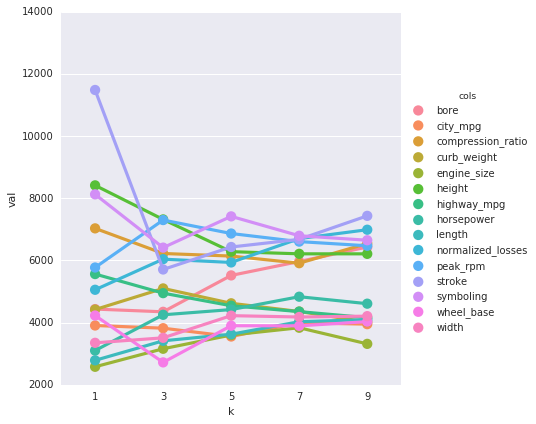

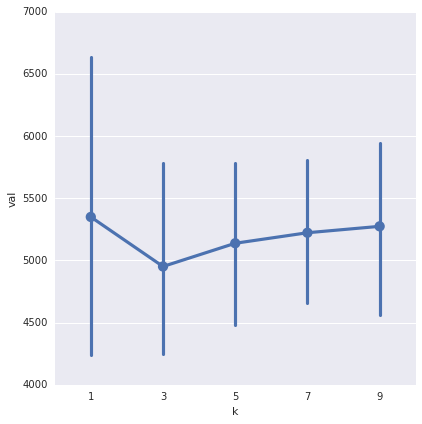

In [20]:
rmse_df = pd.DataFrame(col_k_rmse)
rmse_df['k'] = rmse_df.index
rmse_df = pd.melt(rmse_df, 'k', var_name='cols', value_name='val')


sns.factorplot(x='k',y='val',hue='cols',data=rmse_df,size=6)
plt.show()
sns.factorplot(x='k',y='val',data=rmse_df,size=6)

## Running Multivariate KNN test

In [21]:
#Identify the lowest rmse columns
rmse_df[rmse_df['k'] == 5].sort_values(by='val')

,k,cols,val
7,5,city_mpg,3552.957672
22,5,engine_size,3600.106720
42,5,length,3626.460507
67,5,wheel_base,3899.784039
72,5,width,4223.196157
37,5,horsepower,4418.784715
32,5,highway_mpg,4542.078598
17,5,curb_weight,4620.678681
2,5,bore,5517.116730
47,5,normalized_losses,5934.756647


In [22]:
def knn_train_test(train_col, target_col, df, k):
    np.random.seed(1)
        
    # Randomize order of rows in data frame.
    shuffled_index = np.random.permutation(df.index)
    df = df.reindex(shuffled_index)
    
    train = df.iloc[0:int(df.shape[0]*.75)]
    test = df.iloc[int(df.shape[0]*.75):]

    knn = KNeighborsRegressor(n_neighbors=k)
    
    knn.fit(train[train_col],train[target_col])
    
    prediction = knn.predict(test[train_col])
    
    mse = mean_squared_error(test[target_col],prediction)
    
    rmse = np.sqrt(mse)
    
    return rmse

In [23]:
rmse_mult = {}
for i in range(2,6):
    var = list(rmse_df[rmse_df['k'] == 5].sort_values(by='val')['cols'][0:i].values)
    rmse_mult['var_c{}'.format(i)] = knn_train_test(var,'price',numeric_cars,5)
    

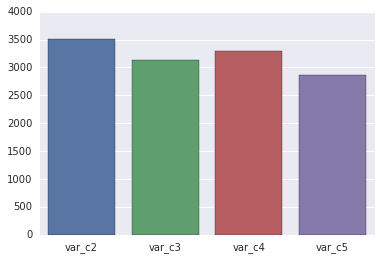

In [24]:
sns.barplot(x=pd.Series(rmse_mult).index,y=pd.Series(rmse_mult).values)

In [25]:
rmse_var = {}
for i in range(3,6):
    var = list(rmse_df[rmse_df['k'] == 5].sort_values(by='val')['cols'][0:i].values)
    rmse_multk = {}
    for k in range(1,26):
        rmse_multk[k] = knn_train_test(var,'price',numeric_cars,k)
    rmse_var['var_c{}'.format(i)] = rmse_multk
rmse_var

{'var_c3': {1: 3413.2997769529325,
  2: 3107.9400085810498,
  3: 2992.7890070662056,
  4: 2860.6435652039659,
  5: 3125.4309692702332,
  6: 3121.0088857375281,
  7: 3225.8686885734155,
  8: 3468.9206757514094,
  9: 3660.9648319302228,
  10: 3742.8729820275539,
  11: 3762.1064762722021,
  12: 3867.4463026722542,
  13: 3879.0667023891647,
  14: 3905.7691871052034,
  15: 3852.7860679685914,
  16: 3950.3136512988931,
  17: 3861.5799161075606,
  18: 3857.3097319297303,
  19: 3739.2275317393096,
  20: 3768.0983240751507,
  21: 3803.9179577549212,
  22: 3848.1813468431988,
  23: 3881.1020668550714,
  24: 3923.2509410924613,
  25: 3967.0015072590932},
 'var_c4': {1: 3472.3175111097175,
  2: 3081.4313166422635,
  3: 2716.154148474759,
  4: 3150.0604517199022,
  5: 3301.5600966568418,
  6: 3125.1192373623803,
  7: 3219.0958954997218,
  8: 3436.1999106415296,
  9: 3529.3398178357165,
  10: 3668.393931092116,
  11: 3735.3342851465377,
  12: 3574.0972960619983,
  13: 3574.0582766017324,
  14: 3653.

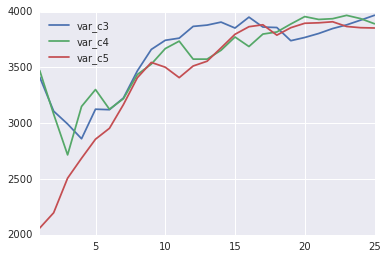

In [26]:
rmse_var_df = pd.DataFrame(rmse_var)
rmse_var_df.plot()

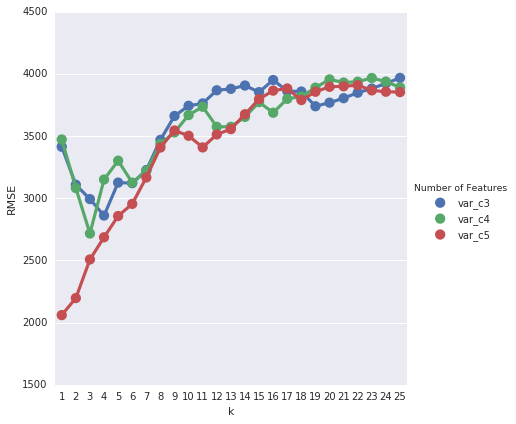

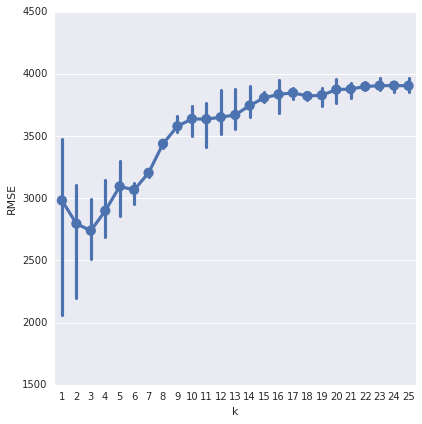

In [27]:
#I want it to be prettier
rmse_var_df['k'] = rmse_var_df.index
rmse_var_df = pd.melt(rmse_var_df, 'k', var_name='Number of Features', value_name='RMSE')

sns.factorplot(x='k',y='RMSE',hue='Number of Features',data=rmse_var_df,size=6)
plt.show()
sns.factorplot(x='k',y='RMSE',data=rmse_var_df,size=6)

The 5 variable model outperforms the other models until k hits about 12 so I would use a 5 variable model with a k of 3 as this appears to be on this model the overall best performing k for RMSE.

## Modifying our KNN Train and Test Function to use k-fold cross validation instead of test/train validation
Lets compare accuracy by using a k-fold cross validation method instead of the test and train method.

In [28]:
def knn_train_test(train_col, target_col, df, k, fold):
    kf = KFold(fold, shuffle=True)
    knn = KNeighborsRegressor(n_neighbors=k)
    mses = cross_val_score(knn, df[train_col], df[target_col], scoring="neg_mean_squared_error", cv=kf)
    rmses = np.sqrt(np.absolute(mses))
    avg_rmse = np.mean(rmses)
    return avg_rmse
    

In [29]:
k_fold_rmse = {}

num_folds = [3, 5, 7, 9, 10, 11, 13, 15, 17, 19, 21, 23]
for i in range(3,6):
    var = list(rmse_df[rmse_df['k'] == 5].sort_values(by='val')['cols'][0:i].values)
    fold_rmse = {}
    for fold in num_folds:
        k_rmse = {}
        for k in range(1,15):
            k_rmse[k] = knn_train_test(var,'price',numeric_cars,k,fold)
        fold_rmse[fold] = k_rmse
    k_fold_rmse['var_c{}'.format(i)] = fold_rmse

In [30]:
rmse_k_fold_df = pd.Panel.from_dict(k_fold_rmse).to_frame()

## Understanding the RMSE for different Folds, Number of Features, and K Values

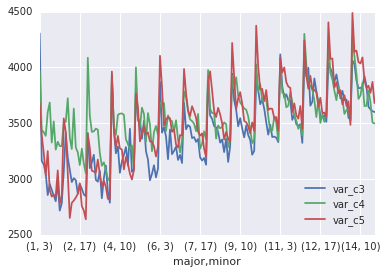

In [31]:
rmse_k_fold_df.plot()

In [32]:
var_list = []
fold_list = []
k_list = []
rmse_list = []

for v in k_fold_rmse.keys():
    for f in k_fold_rmse[v].keys():
        for k in k_fold_rmse[v][f].keys():
            var_list.append(v)
            fold_list.append(f)
            k_list.append(k)
            rmse_list.append(k_fold_rmse[v][f][k])
            
rmse_df = pd.DataFrame({'Number of Features': var_list,
                       'Fold': fold_list,
                       'K': k_list,
                       'RMSE': rmse_list})

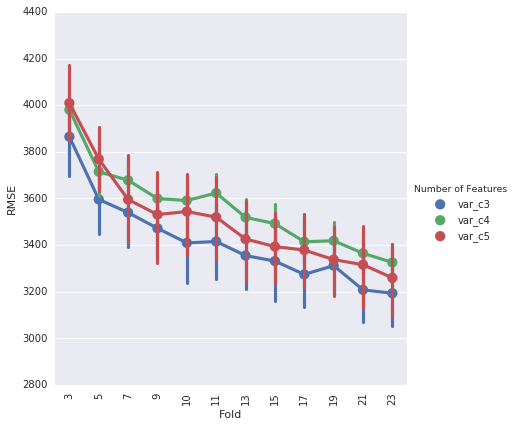

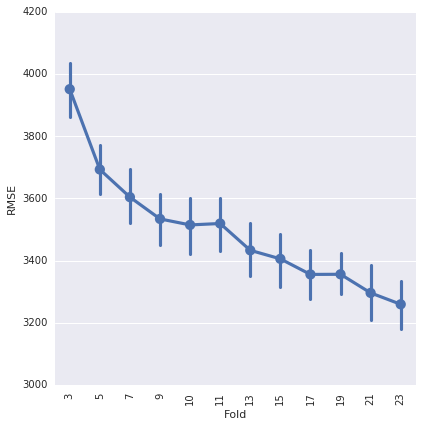

In [33]:
f1 = sns.factorplot(x='Fold',y='RMSE',hue='Number of Features',data=rmse_df.sort_values(by='Fold'),size=6)
f1.set_xticklabels(rotation=90)
plt.show()
f2 = sns.factorplot(x='Fold',y='RMSE',data=rmse_df.sort_values(by='Fold'),size=6)
f2.set_xticklabels(rotation=90)

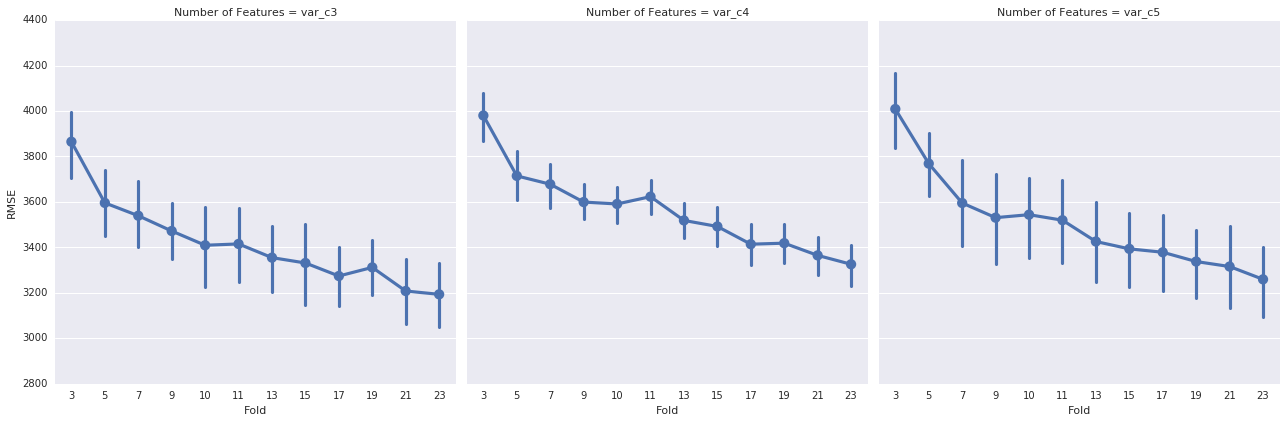

In [78]:
sns.factorplot(x='Fold',y='RMSE',data=rmse_df.sort_values(by='Fold'),col='Number of Features',size=6)

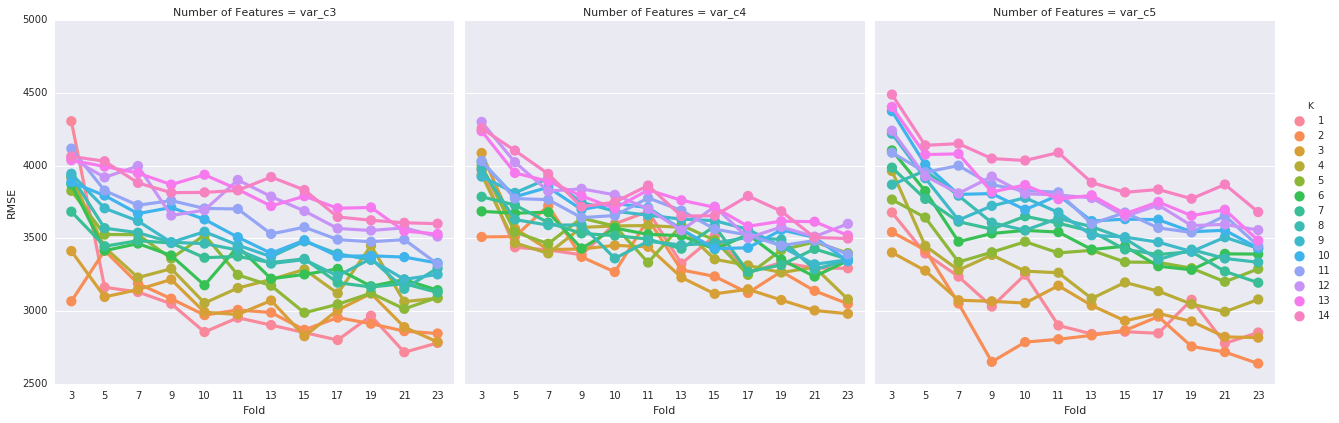

In [79]:
sns.factorplot(x='Fold',y='RMSE',data=rmse_df.sort_values(by='Fold'),col='Number of Features',hue='K',size=6)